In [10]:
# import system libs
import os
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras import layers, models
print ('modules loaded')


modules loaded


### **Read data and store it in dataframe**

In [11]:
# Generate data paths with labels
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# print(labels)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [12]:
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [13]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [14]:
ts_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


### **Split dataframe into train, valid, and test**

In [15]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.50, shuffle= True, random_state= 123)

In [16]:
test_df

,filepaths,labels
569,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
822,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1056,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
84,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
560,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
...,...,...
692,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1032,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1044,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
237,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


### **Create image data generator**

In [17]:
# crobed image size
batch_size = 35
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


### **Data augmentation for glioma class**

In [18]:
# Specify the path to your dataset
dataset_path = '/kaggle/input/brain-tumor-mri-dataset/Training/glioma'

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation in the range [0, 20] degrees
    width_shift_range=0.2,  # Random horizontal shift by up to 20% of the image width
    height_shift_range=0.2, # Random vertical shift by up to 20% of the image height
    shear_range=0.2,        # Shear intensity (shear angle in radians)
    zoom_range=0.2,         # Random zoom by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill points outside the boundaries with the nearest pixel value
)

# Get the list of all image files in the specified directory
image_files = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path)]

# Generate augmented images for each image file
for img_path in image_files:
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Generate augmented images
    augmented_images = []
    for batch in datagen.flow(img_array, batch_size=5):
        augmented_images.append(batch[0].astype('uint8'))
        if len(augmented_images) >= 10:  # Generate 10 augmented images
            break

# Continue with your code or analysis without displaying the augmented images

### **Data augmentation for meningioma class**

In [19]:
# Specify the path to your dataset
dataset_path = '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma'

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation in the range [0, 20] degrees
    width_shift_range=0.2,  # Random horizontal shift by up to 20% of the image width
    height_shift_range=0.2, # Random vertical shift by up to 20% of the image height
    shear_range=0.2,        # Shear intensity (shear angle in radians)
    zoom_range=0.2,         # Random zoom by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill points outside the boundaries with the nearest pixel value
)

# Get the list of all image files in the specified directory
image_files = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path)]

# Generate augmented images for each image file
for img_path in image_files:
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Generate augmented images
    augmented_images = []
    for batch in datagen.flow(img_array, batch_size=5):
        augmented_images.append(batch[0].astype('uint8'))
        if len(augmented_images) >= 10:  # Generate 10 augmented images
            break

# Continue with your code or analysis without displaying the augmented images

### **Data augmentation for notumor class**

In [20]:
# Specify the path to your dataset
dataset_path = '/kaggle/input/brain-tumor-mri-dataset/Training/notumor'

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation in the range [0, 20] degrees
    width_shift_range=0.2,  # Random horizontal shift by up to 20% of the image width
    height_shift_range=0.2, # Random vertical shift by up to 20% of the image height
    shear_range=0.2,        # Shear intensity (shear angle in radians)
    zoom_range=0.2,         # Random zoom by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill points outside the boundaries with the nearest pixel value
)

# Get the list of all image files in the specified directory
image_files = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path)]

# Generate augmented images for each image file
for img_path in image_files:
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Generate augmented images
    augmented_images = []
    for batch in datagen.flow(img_array, batch_size=5):
        augmented_images.append(batch[0].astype('uint8'))
        if len(augmented_images) >= 10:  # Generate 10 augmented images
            break

# Continue with your code or analysis without displaying the augmented images

### **Data augmentation for pituitary class**

In [21]:
# Specify the path to your dataset
dataset_path = '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary'

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation in the range [0, 20] degrees
    width_shift_range=0.2,  # Random horizontal shift by up to 20% of the image width
    height_shift_range=0.2, # Random vertical shift by up to 20% of the image height
    shear_range=0.2,        # Shear intensity (shear angle in radians)
    zoom_range=0.2,         # Random zoom by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill points outside the boundaries with the nearest pixel value
)

# Get the list of all image files in the specified directory
image_files = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path)]

# Generate augmented images for each image file
for img_path in image_files:
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Generate augmented images
    augmented_images = []
    for batch in datagen.flow(img_array, batch_size=5):
        augmented_images.append(batch[0].astype('uint8'))
        if len(augmented_images) >= 10:  # Generate 10 augmented images
            break

# Continue with your code or analysis without displaying the augmented images

### **Show number of images after augmentation**

In [22]:
# Count the total number of images (original + augmented)
total_images = len(image_files) * 10 # Assuming 10 augmented images per original image

print(f'Total number of images in the training path: {total_images}')


Total number of images in the training path: 14570


### **Show sample from train data**

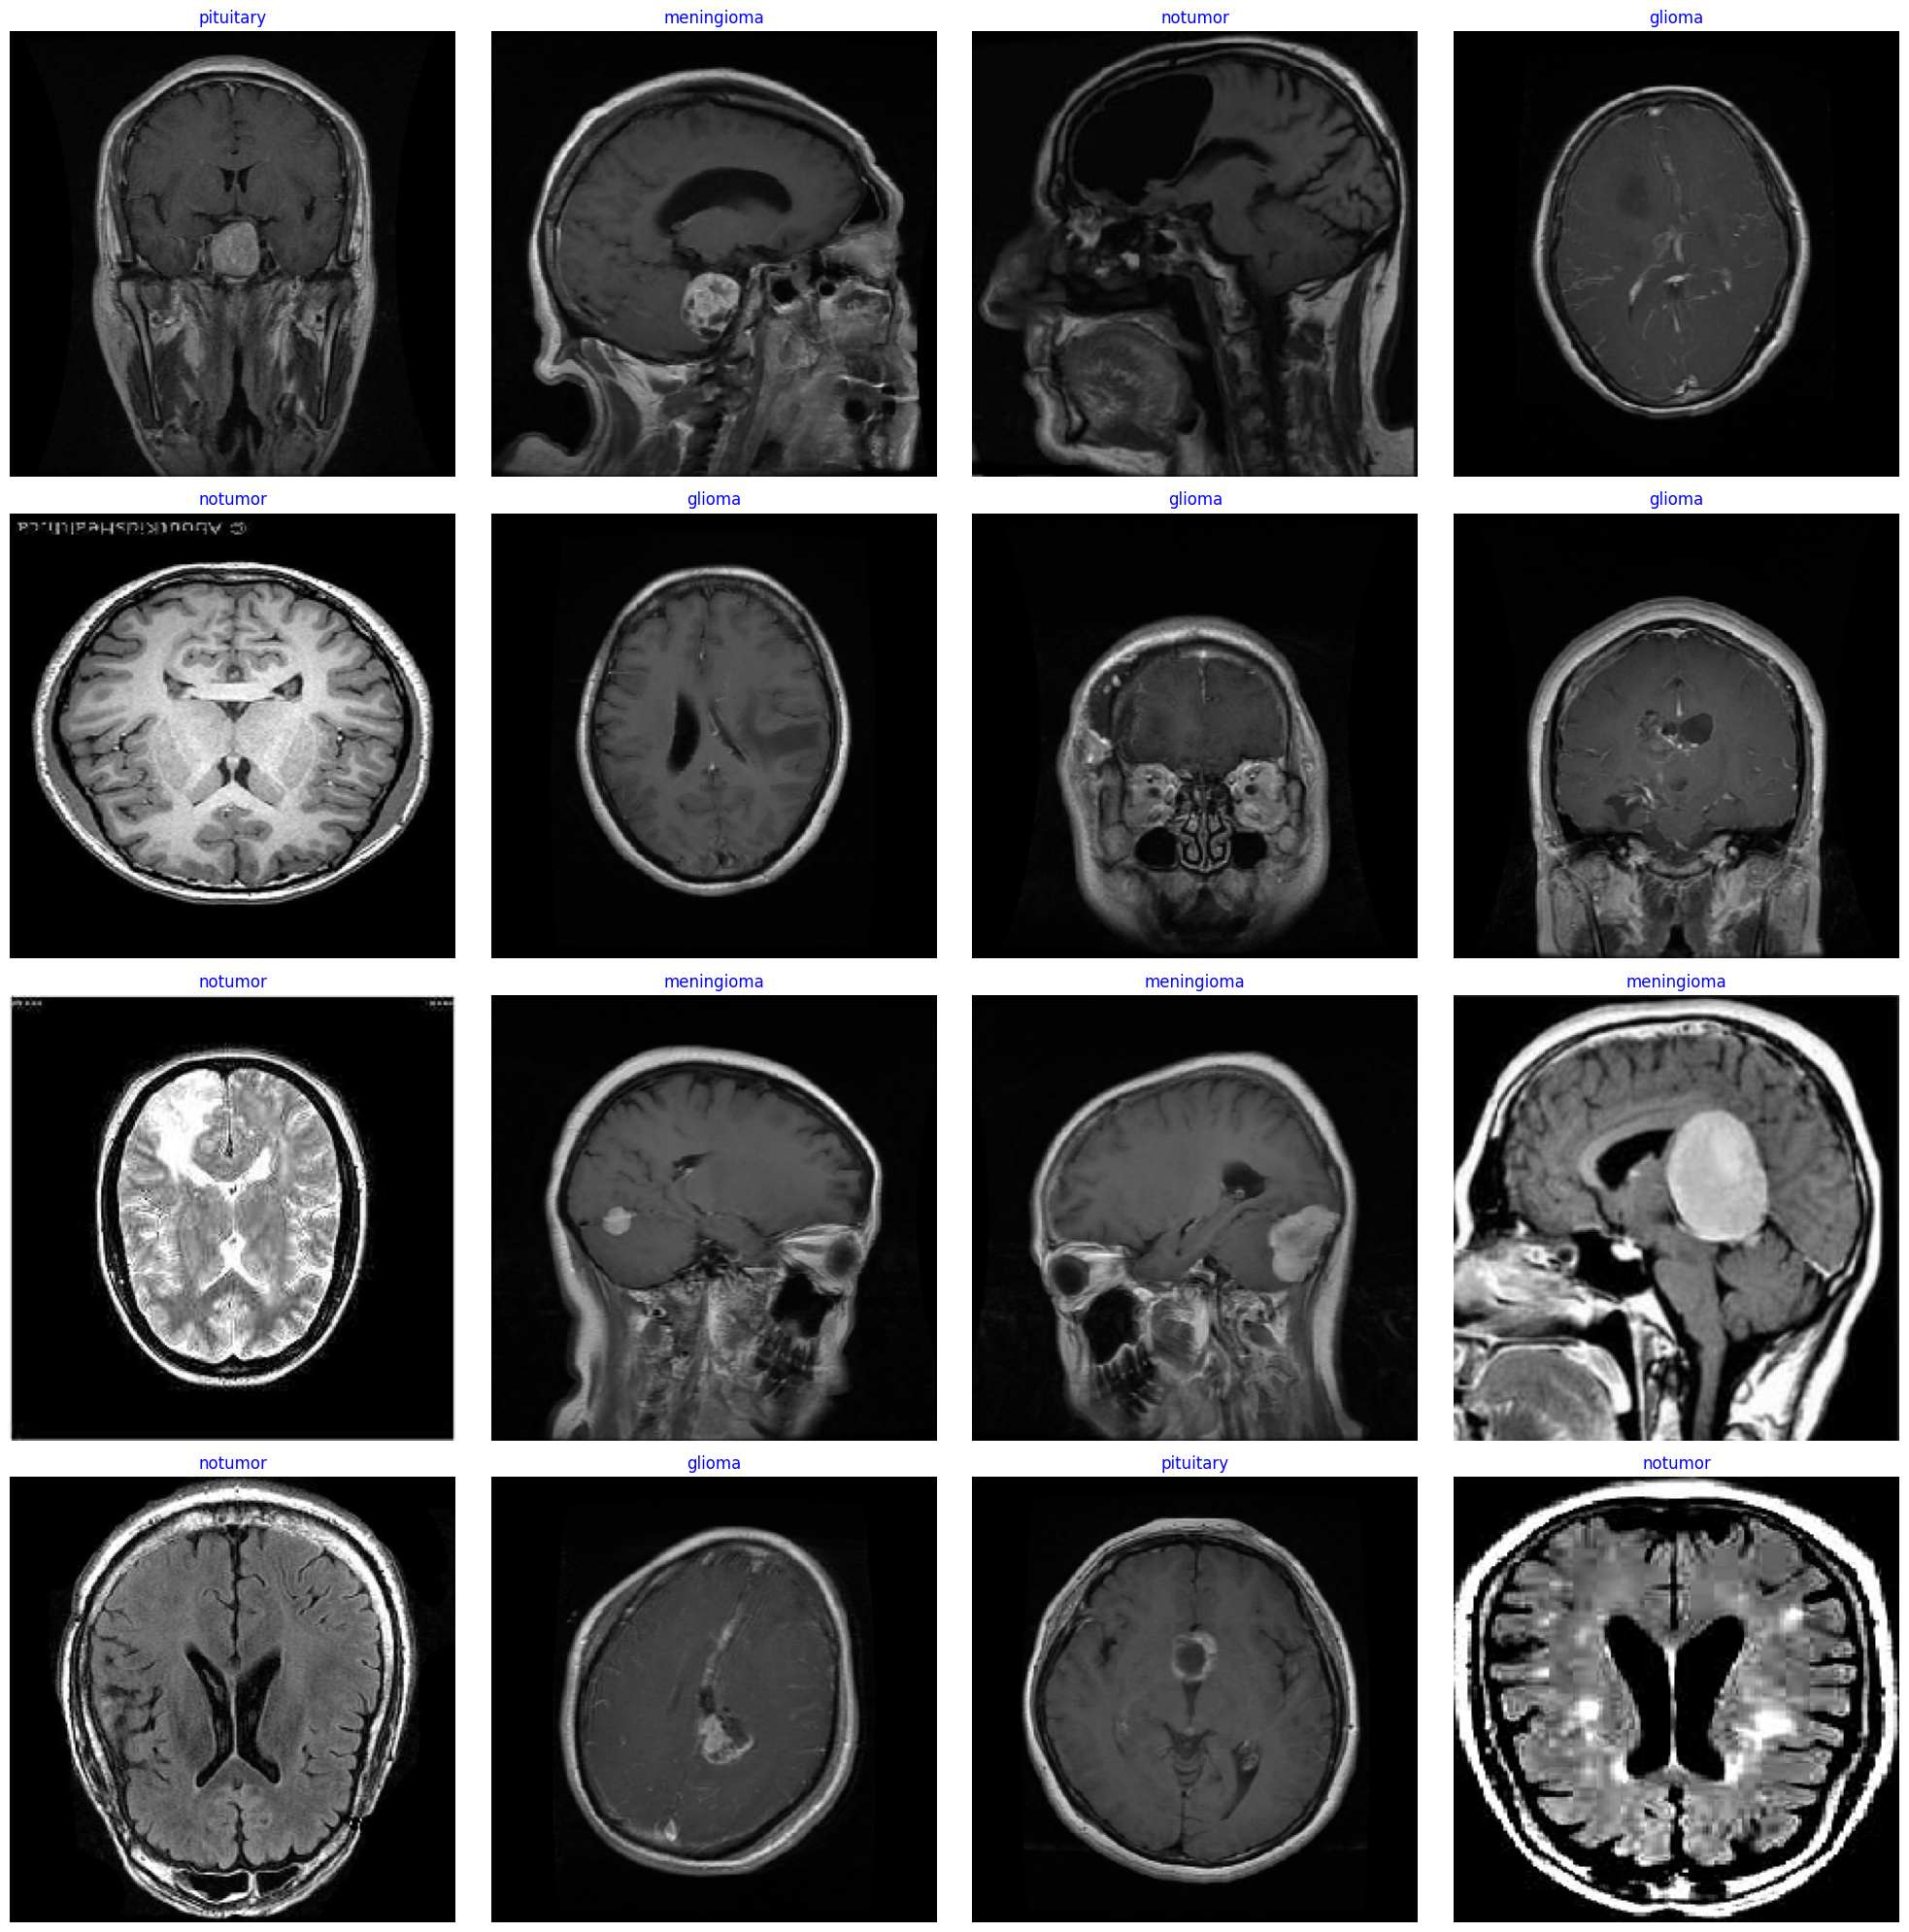

In [23]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Model Structure**


#### **Generic Model Creation**

In [27]:
from tensorflow.keras.regularizers import l2


In [32]:
# crobed image size
batch_size = 35
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

#Creat Pre_traind modle
# We use the EfficientNetB3 from EfficientNet family
base_modle=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False , weights='imagenet' , input_shape=img_shape , pooling='max')
model = Sequential([
   base_modle,
    BatchNormalization(),
    Dense(256,activation='relu'),
    Dropout(rate=0.45,seed=123),
    Dense(class_count,activation='softmax')
])

Learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)

Optimizer = Adamax(learning_rate=Learning_rate_schedule)




model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_4 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 256)               393472    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11184179 (42.66 MB)
Trainable params: 11

In [ ]:
epochs = 30  # number of all epochs in training


history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,validation_steps=None ,shuffle= False)

Epoch 1/30


2023-12-27 20:33:39.920229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


164/164 [==============================] - 128s 445ms/step - loss: 0.3752 - accuracy: 0.8838 - recall_1: 0.8754 - auc_1: 0.9773 - val_loss: 0.2118 - val_accuracy: 0.9237 - val_recall_1: 0.9221 - val_auc_1: 0.9924
Epoch 2/30
164/164 [==============================] - 70s 429ms/step - loss: 0.1054 - accuracy: 0.9676 - recall_1: 0.9646 - auc_1: 0.9969 - val_loss: 0.1079 - val_accuracy: 0.9603 - val_recall_1: 0.9573 - val_auc_1: 0.9978
Epoch 3/30
164/164 [==============================] - 70s 425ms/step - loss: 0.0607 - accuracy: 0.9807 - recall_1: 0.9797 - auc_1: 0.9986 - val_loss: 0.0635 - val_accuracy: 0.9786 - val_recall_1: 0.9771 - val_auc_1: 0.9983
Epoch 4/30
164/164 [==============================] - 70s 425ms/step - loss: 0.0477 - accuracy: 0.9855 - recall_1: 0.9848 - auc_1: 0.9988 - val_loss: 0.0631 - val_accuracy: 0.9725 - val_recall_1: 0.9725 - val_auc_1: 0.9984
Epoch 5/30
164/164 [==============================] - 70s 425ms/step - loss: 0.0345 - accuracy: 0.9886 - recall_1: 0.9

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model.predict_generator(test_gen)    
y_pred = np.argmax(preds, axis=1)    

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
#Save the model
model.save('Brain Tumors.h5')